In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import os

SHIFT_START = 2000
CAPTURE     = 5000

# https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
def read_wav(wav_file_name):
    sr, signal = wavfile.read(wav_file_name)
    return (sr, signal[SHIFT_START:(SHIFT_START + CAPTURE), 0]) # use the first channel (or take their average, alternatively)

def fetch_frequencies(wav_file_name):
    sr, y = read_wav(wav_file_name)
    return y

def show_file_spectrum(wav_file_name):
    sr, y = read_wav(wav_file_name)
    show_array_spectrum(y, sr)

def show_array_spectrum(y, sample_rate=1, normalize_y_axe=True):
    t = np.arange(len(y)) / float(sample_rate)

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, y)
    plt.xlabel('t')
    plt.ylabel('y')
    axes = plt.gca()
    if normalize_y_axe:
        axes.set_ylim([-1e9, 1e9])

    plt.show()

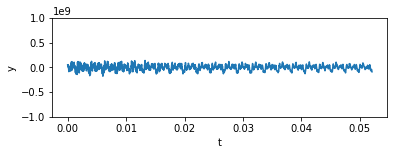

In [2]:
SAMPLES_DIR = 'samples'
TRAIN_DIR = 'train'
TEST_DIR = 'test'

show_file_spectrum(os.path.join(SAMPLES_DIR, 'A', TRAIN_DIR, '1_out_of_tune', 'splitted_chord009.wav'))

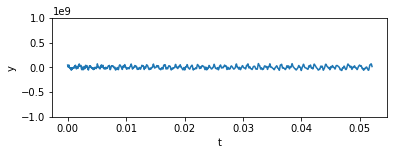

In [3]:
show_file_spectrum(os.path.join(SAMPLES_DIR, 'C', TRAIN_DIR, '1', 'splitted_chord007.wav'))

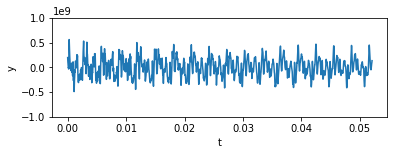

In [4]:
show_file_spectrum(os.path.join(SAMPLES_DIR, 'E', TRAIN_DIR, '1', 'splitted_chord007.wav'))

In [5]:
import glob
import itertools

sound_names_index = {sound_name: idx for idx, sound_name in enumerate(os.listdir(SAMPLES_DIR))}
sound_names_index_reverted = {v: k for k, v in sound_names_index.items()}
print('Following sounds are going to be categorized')
print(list(sound_names_index.keys()))

Following sounds are going to be categorized
['A', 'C', 'E']


In [6]:
def parse_sound_name(path):
    sound_folders_depth = 1
    return os.path.normpath(path).split(os.path.sep)[sound_folders_depth]

def list_files(directory):
    files = glob.glob(os.path.join(SAMPLES_DIR, '*', directory, '*', '*.wav'))
    return {file: sound_names_index[parse_sound_name(file)] for file in files}

train_files = list_files(TRAIN_DIR)
test_files  = list_files(TEST_DIR)

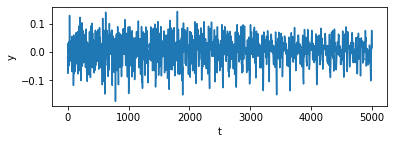

In [7]:
import datetime
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

def rescale(tensor1, tensor2):
    max_value = tf.reduce_max([tf.reduce_max(tensor1), tf.reduce_max(tensor2)])
    min_value = tf.reduce_min([tf.reduce_min(tensor1), tf.reduce_min(tensor2)])
    result1 = tf.truediv(tf.subtract(tensor1, min_value), tf.subtract(max_value, min_value))
    result2 = tf.truediv(tf.subtract(tensor2, min_value), tf.subtract(max_value, min_value))
    return result1 - 0.5, result2 - 0.5 # positive numbers should be interchanged with negative ones

def files_to_tensors(files):
    return tf.convert_to_tensor([tf.convert_to_tensor(fetch_frequencies(file), np.float64) for file in files])

def labeled_files_to_tensors(labeled_files):
    x = files_to_tensors(labeled_files.keys())
    y = tf.convert_to_tensor(list(labeled_files.values()))
    return x, y

x, y           = labeled_files_to_tensors(train_files)
x_test, y_test = labeled_files_to_tensors(test_files)
x, x_test = rescale(x, x_test)
show_array_spectrum(x[0], normalize_y_axe=False)

In [8]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(CAPTURE),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def tensorboard_callback():
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = create_model()
model.fit(x, y, validation_data=(x_test, y_test), callbacks=[tensorboard_callback()], epochs=15)

Train on 93 samples, validate on 14 samples
Epoch 1/15
93/93 [==============================] - 5s 56ms/sample - loss: 1.1080 - accuracy: 0.4946 - val_loss: 0.8125 - val_accuracy: 0.6429
Epoch 2/15
93/93 [==============================] - 3s 32ms/sample - loss: 0.5334 - accuracy: 0.8387 - val_loss: 0.5669 - val_accuracy: 0.7857
Epoch 3/15
93/93 [==============================] - 3s 32ms/sample - loss: 0.2889 - accuracy: 0.9032 - val_loss: 0.5114 - val_accuracy: 0.7143
Epoch 4/15
93/93 [==============================] - 3s 32ms/sample - loss: 0.2043 - accuracy: 0.9355 - val_loss: 0.4552 - val_accuracy: 0.7143
Epoch 5/15
93/93 [==============================] - 3s 29ms/sample - loss: 0.1599 - accuracy: 0.9462 - val_loss: 0.4151 - val_accuracy: 0.7143
Epoch 6/15
93/93 [==============================] - 3s 32ms/sample - loss: 0.1352 - accuracy: 0.9462 - val_loss: 0.3891 - val_accuracy: 0.7857
Epoch 7/15
93/93 [==============================] - 3s 33ms/sample - loss: 0.1199 - accuracy: 0.94

In [9]:
# became kind of legacy after introducing validation_data param.
# But still used to get predictions for specific files.

def predict_files(files):
    files_data = files_to_tensors(files)
    for idx, prediction in enumerate(model.predict(files_data)):
        sound_name = sound_names_index_reverted[list(prediction).index(1)]
        print(f'{sound_name} - {files[idx]}')

predict_files(list(test_files.keys()))

A - samples/A/test/1_out_of_tune/splitted_chord001.wav
A - samples/A/test/1_out_of_tune/splitted_chord003.wav
A - samples/A/test/1_out_of_tune/splitted_chord002.wav
C - samples/C/test/2/splitted_chord001.wav
C - samples/C/test/2/splitted_chord003.wav
C - samples/C/test/2/splitted_chord002.wav
E - samples/C/test/2/splitted_chord004.wav
C - samples/C/test/1/splitted_chord001.wav
C - samples/C/test/1/splitted_chord003.wav
C - samples/C/test/1/splitted_chord002.wav
E - samples/E/test/1/splitted_chord001.wav
E - samples/E/test/1/splitted_chord005.wav
E - samples/E/test/1/splitted_chord002.wav
E - samples/E/test/1/splitted_chord004.wav


In [11]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
